In [1]:
MPH_TO_MPS = 0.44704

TRAFFIC_WAVE = 20 * MPH_TO_MPS  # meters per second
JAM_DENSITY = 1  # vehicles per meter
FREE_FLOW_SPEED = 20 * MPH_TO_MPS

TAU = 1 / (TRAFFIC_WAVE * JAM_DENSITY)  # seconds per vehicle
DELTA = 1 / JAM_DENSITY  # meters per vehicle

HEADWAY = 1  # seconds, time between vehicle spawns

# if TAU != GRANULARITY, will probably not work for a non-simplified model (where speeds restrictied to {0, FREEFLOW_SPEED})
GRANULARITY = 0.01  # base simulation speed in seconds
SIMULATION_TIME = 20  # how long to run the simulation

In [2]:
import simpy
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
import itertools
from sortedcontainers import SortedSet
from dataclasses import dataclass
import plotly.express as px
from typing import Optional, Callable
from scipy import interpolate
from bisect import bisect_left

In [3]:
@dataclass
class HistoryEntry:
    id: int
    time: float
    position: float
    speed: float  # speed at which the car was going between this segment and the PREVIOUS one
        
    def unpack(self) -> tuple[int, float, float, float]:
        return (self.id, self.time, self.position, self.speed)
    
    def get_ordering() -> tuple[str, str, str]:
        return ["id", "time", "position", "speed"]

In [4]:
class BlockerHandler:
    def __init__(self):
        self.blockers = SortedSet()
        
    def add_blocker(self, pos: float):
        assert pos not in self.blockers
        self.blockers.add(pos)
        
    def remove_blocker(self, pos: float):
        self.blockers.remove(pos)
        
    def _find_next_blocker(self, pos: float) -> float:
        idx: int = self.blockers.bisect_left(pos)
        
        if idx == len(self.blockers):
            return float("inf")
        
        return self.blockers[idx]
        
    def check(self, old: float, new: float) -> float:
        # blocker check
        # if the next blocker changes between old/new, that means we passed a blocker
        before: float = self._find_next_blocker(old)
        after: float = self._find_next_blocker(new)
        
        # if the blocker distances are not close (i.e., they are different blockers),
        # then we set the new target distance to before, where the blocker is since this car cannot go past that
        if not math.isclose(before, after):
            return before
            
        return new
    
class TrafficLight():
    id: int = 0
    
    def __init__(self, env: simpy.Environment, pos: float, cycles: tuple[float, ...], blocking_states: tuple[bool, ...], handler: BlockerHandler):
        self.pos = pos  # where the traffic light is
        self.cycles = cycles  # list of the delays of each of the cycles
        self.state = 0  # initial state -- an index for self.cycles
        self.blocking_states = blocking_states  # list of whether each corresponding cycle is blocking or not
        
        assert self.state < len(self.cycles) and self.state >= 0
        assert len(blocking_states) == len(cycles)
        
        self.id = TrafficLight.id
        TrafficLight.id += 1
        
        self.handler: BlockerHandler = handler
            
        self.env: simpy.Environment = env
        self.action = self.env.process(self.run())
        
    def run(self):
        while True:
            if self.blocking_states[self.state]:
                self.handler.add_blocker(self.pos)
            
            yield self.env.timeout(self.cycles[self.state])
            
            if self.blocking_states[self.state]:
                self.handler.remove_blocker(self.pos)
            
            self.state = (self.state + 1) % len(self.cycles)
            
    def refresh(self, env: simpy.Environment):
        self.env = env
        self.state = 0

In [5]:
class Car():
    
    counter = 0
    
    def __init__(self, env: simpy.Environment, inflection_points: list[tuple[float, float]], blocker_handler: BlockerHandler, leader: Optional[list[HistoryEntry]]):
        # start position at the given init_pos (0)
        self.pos = 0.0
        self.init_time = env.now
        
        # set initial and max speed possible
        self.speed: float = FREEFLOW_SPEED
        
        self.blocker_handler = blocker_handler
        
        # TODO: support changes in speed here
        
        # give the current car an id
        self.id = Car.counter
        Car.counter += 1
        
        # variable to track a history of the points that compose the lines that the car traverses in the position-time plot
        self.history: list[HistoryEntry] = [HistoryEntry(self.id, env.now - 0.01, self.pos - self.speed * 0.01, self.speed), HistoryEntry(self.id, env.now, self.pos, self.speed)]
        
        # get functions for time->position for the leader (assume piecewise linear things)
        self.leader_query_position: Callable[[float], float] = None
        self.leader_history: list[tuple[float, float]] = None
        if leader is not None:
            self.leader_query_position = interpolate.interp1d([entry.time for entry in leader], [entry.position for entry in leader], kind="linear", fill_value="extrapolate")
            self.leader_history = leader
            
        # store reference to simpy environment
        self.env = env
        # define the action for the simpy environment
        self.action = self.env.process(self.run())
        
        self.inflection_points = inflection_points  # reference
        
    def query_position(self, time: float):
        # no reason to be querying the position of the future
        # could be querying out of bounds positions from the past due to how spawning works
        assert time <= self.env.now
        
        func = interpolate.interp1d([entry.time for entry in self.history], [entry.position for entry in self.history], kind="linear", fill_value="extrapolate")
        
        return func(time)
    
    def get_leader_data(self, time: float) -> int:
        assert self.leader_history is not None
        
        idx = bisect_left(self.leader_history, time, key=lambda x: x.time)
        
        return idx
        
    def run(self):
        while True:
            yield self.env.timeout(GRANULARITY)
            
            _, prev_time, prev_pos, prev_speed = self.history[-1].unpack()
            
            # by default, just go up free flow * granularity
            # only really works for the first car (no cars in front of it to worry about)
            target_pos: float = prev_pos + FREEFLOW_SPEED * GRANULARITY 
            
            # apply newell model rules
            if self.leader_query_position is not None:
                tau_adj = min(TAU, GRANULARITY)
                target_pos = min(
                    self.query_position(self.env.now - tau_adj) + FREEFLOW_SPEED * tau_adj,  # free-flow conditions; MODIFICATION, functionally equivalent
                    self.leader_query_position(self.env.now - TAU) - DELTA  # congested conditions
                )
                
            
            # apply traffic light rules
            target_pos = self.blocker_handler.check(prev_pos, target_pos)
            # calculate target speed -- i.e., average speed needed to get from prev to target in GRANULARITY time
            target_speed = (target_pos - prev_pos) / (self.env.now - prev_time)
            
            if math.isclose(target_speed, prev_speed):
                self.history[-1] = HistoryEntry(self.id, self.env.now, target_pos, target_speed)
            else:
                # current simplification: cars can only be driving at free flow or stopped, no in-between
                # as such, adjust things to prevent partial slopes
                # TODO: better account for these things--e.g., car changes speed
                if target_speed < prev_speed:
                    target_speed = 0
                else:
                    prev_speed = 0
                    target_speed = FREEFLOW_SPEED
                    
                # stopping from movement
                if math.isclose(target_speed, 0) and not math.isclose(prev_speed, 0):
                    truncated_time = self.env.now - (target_pos - prev_pos) / prev_speed
                    self.history[-1] = HistoryEntry(self.id, truncated_time, target_pos, prev_speed)
                    
                    self.inflection_points.append((truncated_time, target_pos))
                # starting from a stop
                elif not math.isclose(target_speed, 0) and math.isclose(prev_speed, 0):
                    truncated_time = self.env.now - (target_pos - prev_pos) / target_speed
                    self.history[-1] = HistoryEntry(self.id, truncated_time, prev_pos, 0)
                    
                    self.inflection_points.append((truncated_time, prev_pos))
                # both the start/end are not stops -- currently impossible since above assumption enforces one of target, prev
                # speed to be 0 if they are differnet
                else:
                    print(target_speed, prev_speed, self.id, self.env.now, prev_time, target_pos, prev_pos)
                    print(self.history)
                    raise NotImplementedError("TODO")

                self.history.append(HistoryEntry(self.id, self.env.now, target_pos, target_speed))

In [6]:
cars = []
inflections = []
light_positions = set()
handler = BlockerHandler()

def start_simulation(env: simpy.Environment, leader, offset):
    lights: list[TrafficLight] = []
    lights.append(TrafficLight(env, 10, [5, 5], [1, 0], handler))
    
    for light in lights:
        if light.pos not in light_positions:
            light_positions.add(light.pos)
    
    yield env.timeout(offset)
    
    c = Car(env, inflections, handler, leader)
    
    cars.append(c)
    
    while True:
        yield env.timeout(GRANULARITY)

In [7]:
env = simpy.Environment()
env.process(start_simulation(env, None, 0))
env.run(until=SIMULATION_TIME)

i = 1
while i * HEADWAY < SIMULATION_TIME:
    env = simpy.Environment()
    env.process(start_simulation(env, cars[-1].history, i * HEADWAY))
    env.run(until=SIMULATION_TIME)
    i += 1

In [8]:
import matplotlib.axes._axes as axes

def display_dt_diagram_interactive(cars: list[Car]):
    df = pd.DataFrame(list(itertools.chain(*[[x.unpack() for x in car.history] for car in cars])), columns=HistoryEntry.get_ordering())
    
    fig = px.line(df, x="time", y="position", color="id")
    fig.update_layout(
        showlegend=False
    )
    
    return fig

def display_dt_diagram_sns(cars: list[Car], light_positions: list[float]):
    df = pd.DataFrame(list(itertools.chain(*[[x.unpack() for x in car.history] for car in cars])), columns=HistoryEntry.get_ordering())
    
    fig, ax = plt.subplots(figsize=(10, 7))
    ax: axes.Axes
    
    sns.lineplot(data=df, x="time", y="position", hue="id", ax=ax, palette=sns.color_palette(n_colors=1))
    ax.get_legend().remove()
    
    ax.hlines(list(light_positions), xmin=ax.get_xlim()[0], xmax=ax.get_xlim()[1], linestyles="dotted", colors="red")
    
    return fig, ax

In [11]:
display_dt_diagram_interactive(cars)

d:\mambaforge\envs\traffic\lib\site-packages\plotly\express\_core.py:2065: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  sf: grouped.get_group(s if len(s) > 1 else s[0])


In [235]:
@dataclass
class dtPoint:
    time: float
    position: float
        
    def unpack(self) -> tuple[float, float]:
        return (self.time, self.position)
    
    def __eq__(self, other):
        if not isinstance(other, dtPoint):
            raise NotImplementedError("comparison not supported")
        
        return math.isclose(self.time, other.time) and math.isclose(self.position, other.position)
    
def get_slope(point1: dtPoint, point2: dtPoint):
    return (point1.position - point2.position) / (point1.time - point2.time)

class Interface:
    
    def __init__(self, point: dtPoint, slope: float):
        self.point = point
        self.slope = slope
        # TODO: store the state boundaries of the interface
        
        self.bounds: list[tuple[dtPoint, dtPoint]] = []  # limit 2, number of endpoints
        
    def add_cutoff(self, lower: Optional[dtPoint], upper: Optional[dtPoint]):
        assert math.isclose(self.slope, get_slope(self.point, lower))  # along same line
        assert math.isclose(self.slope, get_slope(self.point, upper))  # along same line
        assert not (lower is None and upper is None)  # don't accept redundant cutoffs
        assert lower is None or upper is None or (lower.time < upper.time)  # have lower and upper be oriented correctly
        
        self.bounds.append((lower, upper))  # lower, upper (with respect to time)
        
        if lower is None:
            self.point = upper
        else:
            self.point = lower
        
    def resolve_endpoints(self) -> list[dtPoint]:
        self.endpoints: list[dtPoint] = [None, None]  # lower, upper (with respect to time)
        
        for bounds in self.bounds:
            lower, upper = bounds
            
            if lower is not None:
                if self.endpoints[0] is None:
                    self.endpoints[0] = lower
                elif self.endpoints[0].time < lower.time:
                    self.endpoints[0] = lower
                    
            if upper is not None:
                if self.endpoints[1] is None:
                    self.endpoints[1] = upper
                elif self.endpoints[1].time > upper.time:
                    self.endpoints[1] = upper
                    
        self.bounds.clear()
                    
        return self.endpoints
    
    def __eq__(self, other) -> bool:
        if not isinstance(other, Interface):
            raise NotImplementedError("comparison not supported")
        
        if other.point == self.point:
            return math.isclose(other.slope, self.slope)
        
        return get_slope(self.point, other.point) == other.slope and other.slope == self.slope
            

In [ ]:
# TODO: class for car following model that encapsulates all the parameters
# vf, w, k_j
# method to run the simulation
# method to calculate speeds using the fundamental diagram; (q = f(flow); v_k = q / flow)
# points on the fundamental diagram are traffic states
    # density, density -> speed of the interface between the two ((q(k1) - q(k2)) / (k1 - k2))
    # density -> flow, speed (of car in the state)

In [236]:
inflections

[(1.1115318539727999, 10),
 (4.999999999999938, 10),
 (2.0033786685755195, 9.0),
 (5.111846814602658, 9.0),
 (2.8952254831782187, 8.0),
 (5.223693629205378, 8.0),
 (3.787072297780942, 7.0),
 (5.335540443808099, 7.0),
 (4.678919112383665, 6.0),
 (5.447387258410819, 6.0),
 (10.111531853972776, 10),
 (14.999999999999872, 10),
 (11.003378668575499, 9.0),
 (15.111846814602593, 9.0),
 (11.89522548317822, 8.0),
 (15.223693629205314, 8.0),
 (12.787072297780941, 7.0),
 (15.335540443808034, 7.0),
 (13.678919112383664, 6.0),
 (15.447387258410753, 6.0),
 (14.550765926986388, 5.0),
 (15.559234073013473, 5.0),
 (15.44261274158911, 4.0),
 (15.671080887616194, 4.0)]

In [252]:
1 / (1.1115318539727999 - 2.0033786685755195)

-1.121268791485742

In [260]:
2 / (1.1115318539727999 - 2.8952254831782187)

-1.1212687914857549

In [262]:
inflections_copy = [dtPoint(x[0], x[1]) for x in inflections]

def find_interfaces(inflections: list[dtPoint]) -> list[Interface]:
    interfaces: list[Interface] = []
    
    for i in range(len(inflections_copy)):
        for j in range(i + 1, len(inflections_copy)):
            for k in range(j + 1, len(inflections_copy)):
                if math.isclose(get_slope(inflections_copy[i], inflections_copy[j]), get_slope(inflections[i], inflections_copy[k])):
                    slope = get_slope(inflections_copy[i], inflections_copy[j])
                    point = inflections_copy[i]
                    
                    # throw away any slope 0 interfaces (meaningless)
                    if slope == 0:
                        continue
                    
                    cur = Interface(point, slope)
                    
                    for interface in interfaces:
                        if cur == interface:
                            break
                    else:
                        interfaces.append(Interface(point, slope))
                
    return interfaces

interfaces = find_interfaces(inflections_copy)

C:\Users\fishl\AppData\Local\Temp\ipykernel_25340\3153777017.py:19: UserWarning:


The palette list has fewer values (1) than needed (20) and will cycle, which may produce an uninterpretable plot.



(1.1115318539727999, 10) -1.121268791485742
(4.999999999999938, 10) -8.940799999999987
(2.0033786685755195, 9.0) -1.1212687914857675
(2.8952254831782187, 8.0) -1.1212687914857375
(10.111531853972776, 10) -1.1212687914857387
(14.999999999999872, 10) -8.940799999999916
(11.003378668575499, 9.0) -1.1212687914857409
(15.111846814602593, 9.0) -8.940799999999987
(11.89522548317822, 8.0) -1.1212687914857387
(15.223693629205314, 8.0) -8.940800000000058


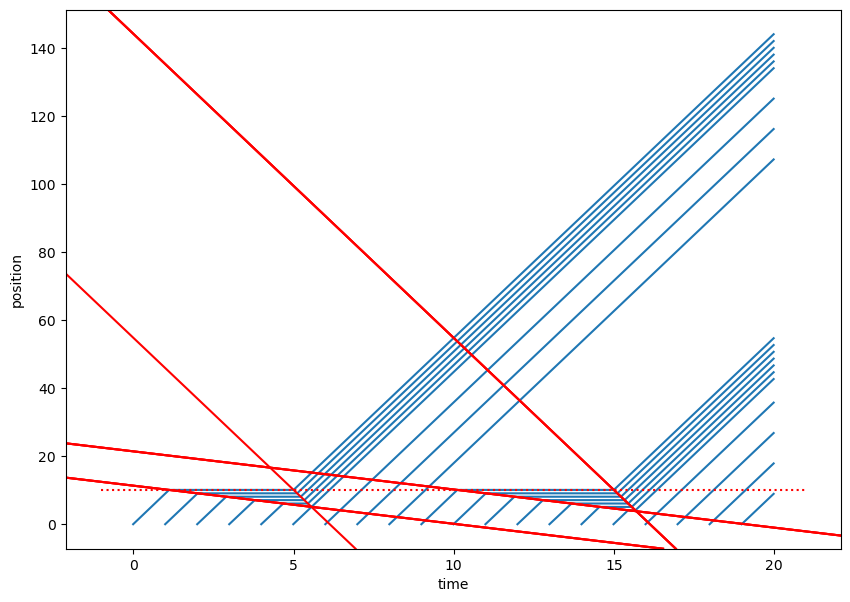

In [263]:
import matplotlib.pyplot as plt

fig, ax = display_dt_diagram_sns(cars, light_positions)
ax: axes.Axes

for interface in interfaces:
    print(interface.point.unpack(), interface.slope)
    ax.axline(interface.point.unpack(), slope=interface.slope, color="r")